# Spark Introduction

This example shows how the Pilot-Abstraction is used to spawn a Spark job inside of YARN. We show how to combine the Pilot and Spark programming modelling using several examples.


   - Spark Documentation: <http://spark.apache.org/docs/latest/>
   - Pilot-Spark: <https://pypi.python.org/pypi/SAGA-Hadoop/>


## 1. Initialize Spark

**Please edit env.py in HOME directory to make sure to point to right Spark installation!**

The following codes shows how the Pilot-Abstraction is used to connect to an existing YARN cluster and startup Spark.

In [1]:
%matplotlib inline
%run ../env.py
%run ../util/init_spark.py

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

pilotcompute_description = {
    "service_url": "yarn-client://yarn-aws.radical-cybertools.org",
    "number_of_processes": 2
}

print "SPARK HOME: %s"%os.environ["SPARK_HOME"]
print "PYTHONPATH: %s"%os.environ["PYTHONPATH"]

pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)
sc = pilot_spark.get_spark_context()

SPARK Home: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6
SPARK HOME: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6
PYTHONPATH: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6/python:/usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip


After the Spark application has been submitted it can be monitored via the YARN web interface: <http://yarn-aws.radical-cybertools.org:8088/> or by executing the following command:

In [2]:
output=!yarn application -list -appTypes Spark -appStates RUNNING
print_application_url(output)

,User,Name,Spark Application URL
0,radical,Pilot-Spark,http://yarn-aws.radical-cybertools.org:8088/proxy/application_1447000128355_0758
1,radical,Pilot-Spark,http://yarn-aws.radical-cybertools.org:8088/proxy/application_1447000128355_0659


## 2. Spark: Hello RDD Abstraction

The RDD Abstraction builts on the popular MapReduce programming model and extends it by supporting a greater variety of transformations!

Analyze the NASA log file!

**Line Count:** How many lines of logs do we have?

In [3]:
text_rdd = sc.textFile("/data/nasa/")
text_rdd.count()

1891715

**Word Count:** How many words?

In [4]:
text_rdd.flatMap(lambda line: line.split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda x,y: x+y).take(10)

[(u'', 2817),
 (u'[13/Jul/1995:17:48:56', 1),
 (u'[13/Jul/1995:17:48:54', 1),
 (u'[13/Jul/1995:17:48:52', 3),
 (u'/cgi-bin/imagemap/countdown?107,174', 19),
 (u'[13/Jul/1995:17:48:50', 3),
 (u'[22/Jul/1995:12:10:41', 1),
 (u'[03/Jul/1995:02:03:47', 2),
 (u'[16/Jul/1995:14:34:31', 1),
 (u'[07/Jul/1995:18:18:55', 1)]

**HTTP Response Code Count:** How many HTTP errors did we observe?

In [5]:
text_rdd = sc.textFile("/data/nasa/")
text_rdd.filter(lambda x: len(x)>8).map(lambda x: (x.split()[-2],1)).reduceByKey(lambda x,y: x+y).collect()

[(u'403', 54),
 (u'302', 46573),
 (u'304', 132627),
 (u'500', 62),
 (u'501', 14),
 (u'200', 1701534),
 (u'404', 10845),
 (u'400', 5)]

## 3. Spark-SQL

[Dataframes](http://spark.apache.org/docs/latest/sql-programming-guide.html) are an abstraction that allows the high-level reasoning on structured data. Using DataFrames data can easily be filtered, aggregated and combined. Further, they are used for machine learning tasks.

In [6]:
from pyspark.sql import SQLContext, Row
sqlContext = SQLContext(sc)
text_filtered = text_rdd.filter(lambda x: len(x)>8)
logs = text_filtered.top(20)
cleaned = text_filtered.map(lambda l: (l.split(" ")[0], l.split(" ")[3][1:], l.split(" ")[6], l.split(" ")[-2]))
rows = cleaned.map(lambda l: Row(referer=l[0], ts=l[1], response_code=l[3]))
schemaLog = sqlContext.createDataFrame(rows)
schemaLog.registerTempTable("row")

In [7]:
rows.take(2)

[Row(referer=u'199.72.81.55', response_code=u'200', ts=u'01/Jul/1995:00:00:01'),
 Row(referer=u'unicomp6.unicomp.net', response_code=u'200', ts=u'01/Jul/1995:00:00:06')]

In [13]:
df=sqlContext.sql("select response_code, count(*) as count from row group by response_code")

In [14]:
df.show()

+-------------+-------+
|response_code|  count|
+-------------+-------+
|          500|     62|
|          501|     14|
|          400|      5|
|          403|     54|
|          404|  10845|
|          302|  46573|
|          304| 132627|
|          200|1701534|
+-------------+-------+



Spark Dataframes interoperate with Pandas Dataframes. Small results can be further processed using [Pandas](http://pandas.pydata.org/) and Python tools, e.g. [Matplotlib ](http://matplotlib.org/) and [Bokeh](http://bokeh.pydata.org/) for plotting.

In [15]:
pdf=df.toPandas()

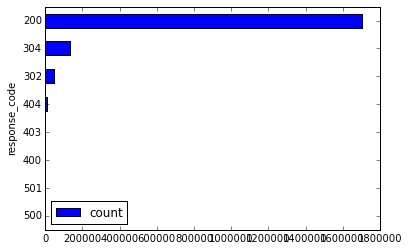

In [22]:
%matplotlib inline
pdf.plot(x='response_code', y='count', kind='barh')

## 4. Stop Pilot-Spark Application

In [ ]:
pilot_spark.cancel()

## 5. Installation Notes

Pilot-Spark is part of [SAGA-Hadoop](https://pypi.python.org/pypi/SAGA-Hadoop/)

    pip install saga-hadoop